# Importind data and Choosing Specific Data from sales dataset

In [ ]:
import pandas as pd
sales_df = pd.read_csv('/content/sales_data.csv')

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145670 entries, 0 to 145669
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sales_id               145670 non-null  object 
 1   shipping_date          145670 non-null  object 
 2   material_id            145670 non-null  int64  
 3   material_description   145670 non-null  object 
 4   std_shipping_quantity  145670 non-null  float64
 5   country                145670 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [ ]:
sales_df['shipping_date'] = pd.to_datetime(sales_df['shipping_date'])

In [ ]:
# Aggregating sales by month for each material_id
sales_df['year_month'] = sales_df['shipping_date'].dt.to_period('M')
monthly_sales = sales_df.groupby(['material_id', 'year_month'])['std_shipping_quantity'].sum().reset_index()

In [ ]:
# Create columns 'date' and 'sale_quantity'
monthly_sales['date'] = monthly_sales['year_month'].dt.to_timestamp()
monthly_sales['sale_quantity'] = monthly_sales['std_shipping_quantity']
monthly_sales = monthly_sales.drop(columns=['year_month','std_shipping_quantity'])

**material id is "8800862", Description is "Amistar Top" and packet_size is "1" and unit is "L"**

In [ ]:
#Description is "Amistar Top" and packet_size is "1" and unit is "L"
material_id_to_forecast = 8800862
material_sales = monthly_sales[monthly_sales['material_id'] == material_id_to_forecast].drop(columns='material_id')

In [ ]:
material_sales.set_index('date', inplace=True)
material_sales.head(2)

,sale_quantity
date,
2020-01-01,3327.0
2020-02-01,3368.0


<Axes: xlabel='date'>

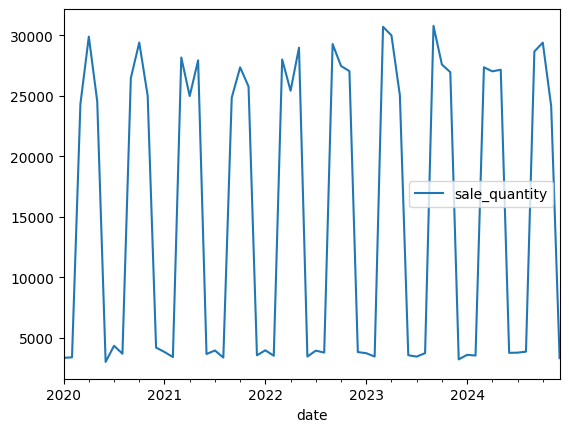

In [ ]:
import matplotlib.pyplot as plt
material_sales.plot()

# Augmented Dickey–Fuller test (ADF)

In [ ]:
from statsmodels.tsa.stattools import adfuller

n0 = The time series has a unit root, i.e., it is non-stationary. <br> n1 = The time series does not have a unit root, i.e., it is stationary.

In [ ]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[0] <= -2.9:
        print("ADF Statistics: strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("ADF Statistics: weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

    if result[1] <= 0.05:
        print("P-Value: strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("P-Value: weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_test(material_sales['sale_quantity'])

ADF Statistics: -2.744475153141304
p- value: 0.06665321580372524
ADF Statistics: weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
P-Value: weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
material_sales.shape

(60, 1)

In [ ]:
# Use Techniques Differencing -- 1 month
material_sales['sale_quantity First Difference']=material_sales['sale_quantity']-material_sales['sale_quantity'].shift(1)
material_sales.head(3)

,sale_quantity,sale_quantity First Difference
date,,
2020-01-01,3327.0,NaN
2020-02-01,3368.0,41.0
2020-03-01,24331.0,20963.0


In [ ]:
adf_test(material_sales['sale_quantity First Difference'].dropna())

ADF Statistics: -6.072440955046363
p- value: 1.1423036184053157e-07
ADF Statistics: strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
P-Value: strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


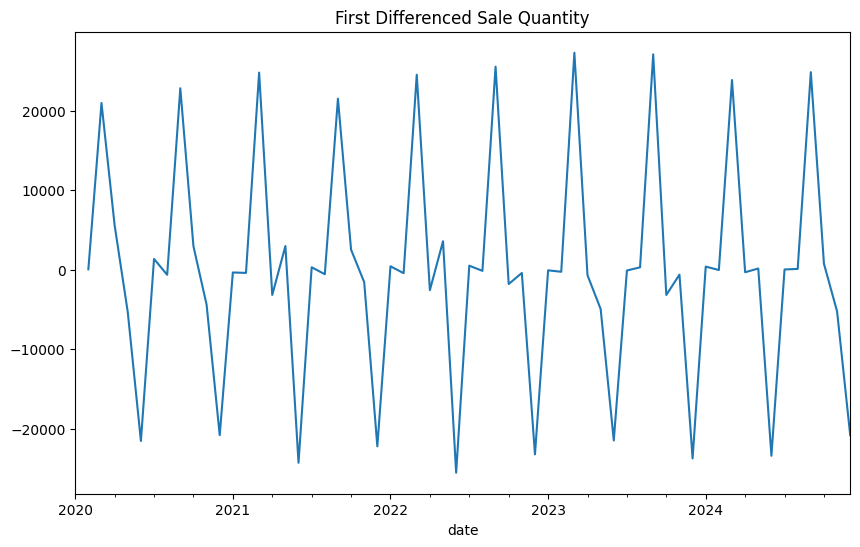

In [ ]:
import matplotlib.pyplot as plt
material_sales['sale_quantity First Difference'].plot(figsize=(10, 6))
plt.title("First Differenced Sale Quantity")
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

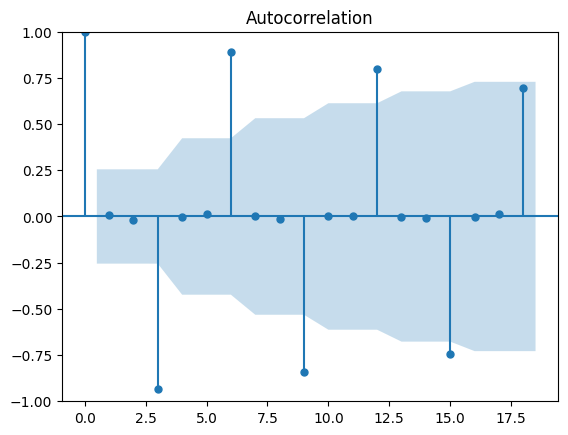

In [ ]:
acf = plot_acf(material_sales['sale_quantity First Difference'].dropna())

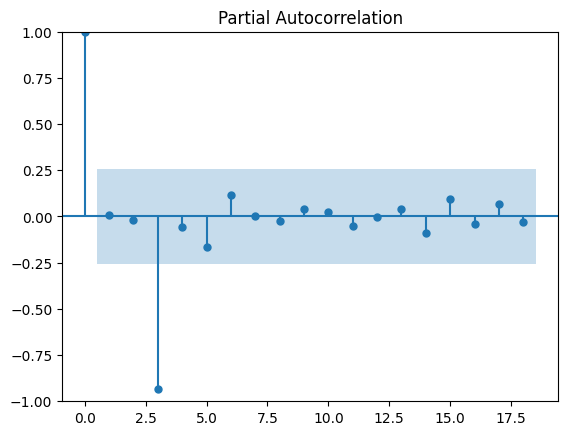

In [ ]:
pacf = plot_pacf(material_sales['sale_quantity First Difference'].dropna())

# Train Test Split

In [ ]:
cutoff_date = '2024-01-01'
material_sales_ = material_sales.reset_index()
material_sales_.head(2)

,date,sale_quantity,sale_quantity First Difference
0,2020-01-01,3327.0,NaN
1,2020-02-01,3368.0,41.0


In [ ]:
material_sales_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            60 non-null     datetime64[ns]
 1   sale_quantity                   60 non-null     float64       
 2   sale_quantity First Difference  59 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


In [ ]:
train_data = material_sales_[material_sales_['date'] < cutoff_date]
test_data = material_sales_[material_sales_['date'] >= cutoff_date]

In [ ]:
train_data = train_data.set_index("date")
test_data = test_data.set_index("date")

# Modeling using SARIMA Model

In [ ]:
# SARIMA(p,d,q) where:
# p = number of lag observations (lags in autoregression) --- pacf
# d = number of times the data have been differenced
# q = size of the moving average window   --- acf

# SARIMA hyperparameters
p, d, q = 2, 1, 6

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA=SARIMAX(train_data['sale_quantity'],order=(p,d,q),seasonal_order=(0,1,0,6))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
model_SARIMA_fit=model_SARIMA.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      sale_quantity   No. Observations:                   48
Model:             SARIMAX(2, 1, 6)x(0, 1, [], 6)   Log Likelihood                -364.426
Date:                            Thu, 19 Dec 2024   AIC                            746.852
Time:                                    12:51:21   BIC                            762.274
Sample:                                01-01-2020   HQIC                           752.468
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5070      0.218     -6.901      0.000      -1.935      -1.079
ar.L2         -0.8210      0.250     -3.285      0.001      -1.311      -0.331
ma.L1          0.3476      0.279      1.245      0.213      -0.200       0.895
ma.L2         -0.2410      0.173     -1.395      0.163      -0.580       0.098
ma.L3         -0.2975      0.213     -1.395      0.163      -0.715       0.120
ma.L4          0.1826      0.172      1.060      0.289      -0.155       0.520
ma.L5         -0.0756      0.110     -0.685      0.493      -0.292       0.141
ma.L6         -0.0257      0.093     -0.275      0.783      -0.209       0.157
sigma2      1.795e+06   3.37e+05      5.333      0.000    1.14e+06    2.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.43   Prob(JB):                         0.59
Heteroskedasticity (H):               0.70   Skew:                            -0.39
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Prediction and Error Analysis

In [ ]:
forecast = model_SARIMA_fit.forecast(steps=12)
test_data['SARIMA_forecast'] = forecast
test_data['SARIMA_residual'] = test_data['sale_quantity'] - forecast

In [ ]:
test_data.tail(5)

,sale_quantity,sale_quantity First Difference,SARIMA_forecast,SARIMA_residual
date,,,,
2024-08-01,3839.0,83.0,3806.926044,32.073956
2024-09-01,28680.0,24841.0,31107.573014,-2427.573014
2024-10-01,29411.0,731.0,27967.745655,1443.254345
2024-11-01,24148.0,-5263.0,26938.535999,-2790.535999
2024-12-01,3302.0,-20846.0,3690.760602,-388.760602


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2024-01-01 to 2024-12-01
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   sale_quantity                   12 non-null     float64
 1   sale_quantity First Difference  12 non-null     float64
 2   SARIMA_forecast                 12 non-null     float64
 3   SARIMA_residual                 12 non-null     float64
dtypes: float64(4)
memory usage: 480.0 bytes


In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
mae = mean_absolute_error(test_data['sale_quantity'], test_data['SARIMA_forecast'])
rmse = root_mean_squared_error(test_data['sale_quantity'], test_data['SARIMA_forecast'],)
mape = (abs(test_data['sale_quantity'] - test_data['SARIMA_forecast']) / test_data['sale_quantity']).mean() * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 1063.6337651883002
RMSE: 1561.8769291182107
MAPE: 5.90409768587854


<Axes: xlabel='date'>

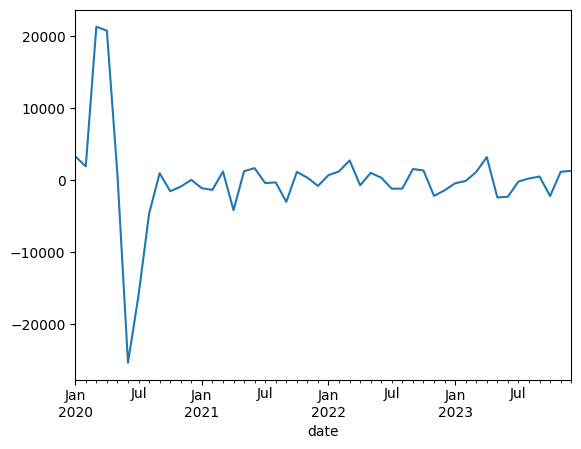

In [ ]:
model_SARIMA_fit.resid.plot()

<Axes: ylabel='Density'>

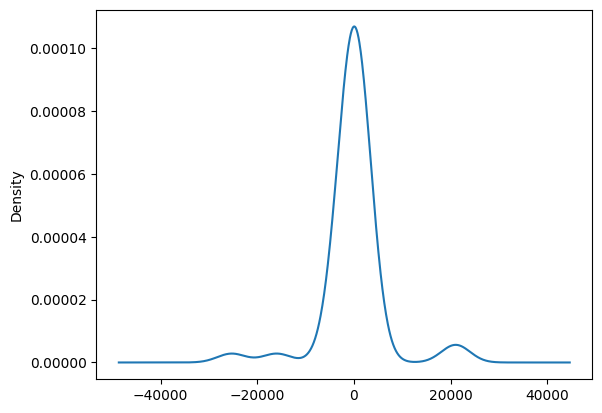

In [ ]:
model_SARIMA_fit.resid.plot(kind='kde')

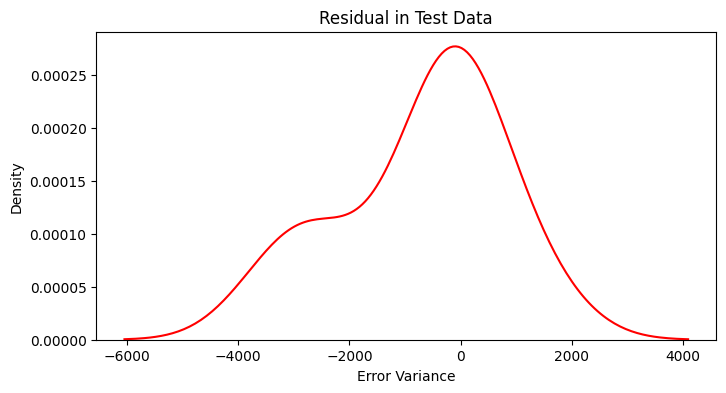

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

sns.kdeplot(test_data['SARIMA_residual'], color='red')
plt.xlabel('Error Variance')
plt.ylabel('Density')
plt.title('Residual in Test Data')
plt.show()

# Forcast Data vs Recorded Data Visualization

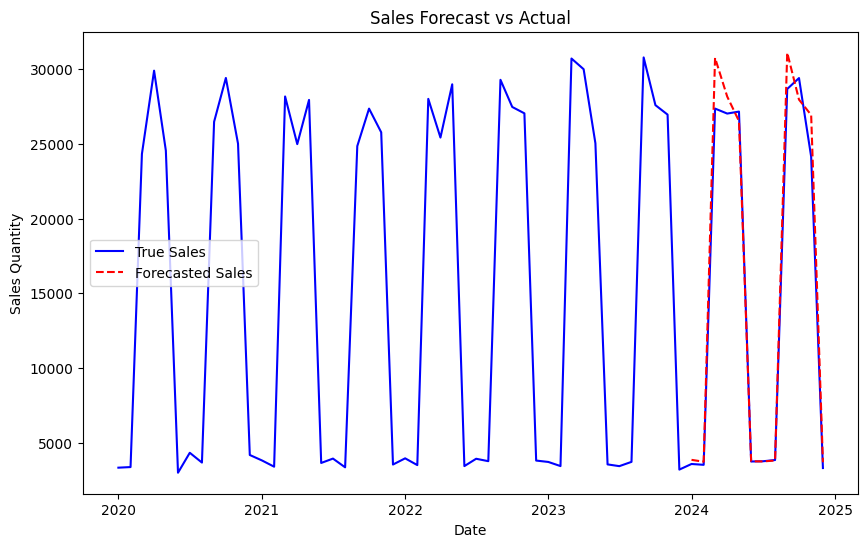

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(material_sales.index, material_sales['sale_quantity'], label='True Sales', color='blue')
plt.plot(test_data.index, test_data['SARIMA_forecast'], label='Forecasted Sales', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.title('Sales Forecast vs Actual')
plt.legend()
plt.show()